## Imports and Data Loading

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.utils import resample
import scipy
from numpy.fft import fft
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
np.random.seed(8055)

In [148]:
# load data
hr = pd.read_csv('data/alpaca_hr.csv')
resp = pd.read_csv('data/alpaca_resp.csv')
sao2 = pd.read_csv('data/alpaca_sao2.csv')

hr['offset'] = hr['offset'] / 60
resp['offset'] = resp['offset'] / 60
sao2['offset'] = sao2['offset'] / 60

gcs = pd.read_csv('data/patient_motor.csv')
gcs = gcs[gcs['observationoffset'] > -1]
gcs['observationoffset'] = gcs['observationoffset'] / 60
final_gcs_id = gcs.groupby('patientunitstayid')['observationoffset'].transform(max) == gcs['observationoffset']

final_gcs = gcs[final_gcs_id]
#display(final_gcs)

#display(hr)
#display(resp)
#display(sao2)

,patientunitstayid,offset,value
0,143274,1.0,NaN
1,143274,6.0,NaN
2,143274,11.0,NaN
3,143274,16.0,NaN
4,143274,21.0,NaN
...,...,...,...
566,143274,2831.0,103.0
567,143274,2836.0,112.0
568,143274,2841.0,109.0
569,143274,2846.0,142.0


,patientunitstayid,offset,value
0,143274,0.016667,NaN
1,143274,0.100000,NaN
2,143274,0.183333,NaN
3,143274,0.266667,NaN
4,143274,0.350000,NaN
...,...,...,...
566,143274,47.183333,103.0
567,143274,47.266667,112.0
568,143274,47.350000,109.0
569,143274,47.433333,142.0


# Lab Data

In [95]:
# Loading lab data
lab = pd.read_csv('data/lab_data.csv')
lab = lab.loc[lab['labresultoffset'] > -1]
lab = lab.loc[lab['labresultoffset'] <= 24*60]
display(lab)
labtypes = list(lab['labname'].drop_duplicates())

,Unnamed: 0,patientunitstayid,diagnosisstring,labid,patientunitstayid.1,labresultoffset,labtypeid,labname,labresult,labresulttext,labmeasurenamesystem,labmeasurenameinterface,labresultrevisedoffset
14,14,976143,burns/trauma|trauma - CNS|spinal cord injury|c...,231365792,976143,1259,4.0,bedside glucose,106.00,106,mg/dL,mg/dL,1259
82,82,2896749,neurologic|trauma - CNS|intracranial injury,653612385,2896749,534,3.0,PTT,31.40,31.4,sec,sec,534
87,87,2896749,neurologic|trauma - CNS|intracranial injury,669448807,2896749,534,3.0,Hct,36.70,36.7,%,%,534
107,107,2896749,neurologic|trauma - CNS|intracranial injury,648051805,2896749,1059,2.0,Vancomycin - trough,16.70,16.7,mcg/mL,ug/mL,1059
131,131,2896749,neurologic|trauma - CNS|intracranial injury,648754398,2896749,534,3.0,PT,14.60,14.6,sec,sec,534
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374604,374604,962326,neurologic|trauma - CNS|intracranial injury|wi...,228891620,962326,294,1.0,total protein,5.10,5.1,g/dL,g/dL,342
2374608,374608,962326,neurologic|trauma - CNS|intracranial injury|wi...,228891619,962326,294,1.0,bicarbonate,23.00,23,mmol/L,mmol/L,342
2374610,374610,962326,neurologic|trauma - CNS|intracranial injury|wi...,228891613,962326,294,1.0,alkaline phos.,60.00,60,Units/L,IU/L,342
2374612,374612,962326,neurologic|trauma - CNS|intracranial injury|wi...,228891612,962326,294,1.0,creatinine,1.25,1.250,mg/dL,mg/dL,342


In [96]:
# Getting table of averages over first 24 hours
l = labtypes[0]
labtypedata = lab[lab['labname'] == l]
labtypedata_avgs = labtypedata.groupby('patientunitstayid').mean()['labresult']
labtypedata_avgs = labtypedata_avgs.to_frame()
labtypedata_avgs = labtypedata_avgs.reset_index()
labtypedata_avgs =labtypedata_avgs.rename(columns = {'labresult':l})
for l in labtypes[1:]:
    labtypedata = lab[lab['labname'] == l]
    labtypedata_avgs1 = labtypedata.groupby('patientunitstayid').mean()['labresult']
    labtypedata_avgs1 = labtypedata_avgs1.to_frame()
    labtypedata_avgs1 = labtypedata_avgs1.reset_index()
    labtypedata_avgs1 =labtypedata_avgs1.rename(columns = {'labresult':l})
    labtypedata_avgs = labtypedata_avgs.merge(labtypedata_avgs1, how='outer', on='patientunitstayid')

In [97]:
labtypedata_avgs = labtypedata_avgs[labtypedata_avgs.columns[labtypedata_avgs.isnull().mean() < 0.2]]
#labtypedata_avgs.head()

In [98]:
lab_avgs_map = {}
for l in labtypes:
    if l in labtypedata_avgs.columns:
        col = list(labtypedata_avgs[l].dropna())
        if len(col) != 0:
            avg = sum(col)/len(col)
            lab_avgs_map[l] = avg
        else:
            labtypedata_avgs = labtypedata_avgs.drop(columns=l)
# print(lab_avgs_map)

In [99]:
# Filling in na values for labtypedata_avgs.columns with averages
# for that column
for l in labtypedata_avgs.columns:
    if l != 'patientunitstayid':
        col = labtypedata_avgs[l]
        labtypedata_avgs[l] = col.fillna(lab_avgs_map[l])
#labtypedata_avgs.head()

In [142]:
# Getting table of measurement counts over first 24 hours
l = labtypes[0]
labtypedata = lab[lab['labname'] == l]
labtypedata_cts = labtypedata.groupby('patientunitstayid').count()['labresult']
labtypedata_cts = labtypedata_cts.to_frame()
labtypedata_cts = labtypedata_cts.reset_index()
labtypedata_cts =labtypedata_cts.rename(columns = {'labresult':l})
for l in labtypes[1:]:
    labtypedata = lab[lab['labname'] == l]
    labtypedata_cts1 = labtypedata.groupby('patientunitstayid').count()['labresult']
    labtypedata_cts1 = labtypedata_cts1.to_frame()
    labtypedata_cts1 = labtypedata_cts1.reset_index()
    labtypedata_cts1 =labtypedata_cts1.rename(columns = {'labresult':l})
    labtypedata_cts = labtypedata_cts.merge(labtypedata_cts1, how='outer', on='patientunitstayid')

In [143]:
labtypedata_cts = labtypedata_cts[labtypedata_cts.columns[labtypedata_cts.isnull().mean() < 0.2]]
labtypedata_cts = labtypedata_cts.apply(lambda x: x.fillna(x.median()),axis=0)

In [144]:
#print(labtypedata_cts.median())
labtypedata_cts = labtypedata_cts > labtypedata_cts.median()
#labtypedata_cts.head(20)

# Demographic Data

In [104]:
# Loading demographic data
demographic_all = pd.read_csv('data/patient_demographics_data.csv')

#demographic_all.head()

died = demographic_all.loc[:, ['patientunitstayid', 'unitdischargestatus']]
died['alive'] = died['unitdischargestatus'] == 'Alive'
died = died.drop_duplicates()
#display(died)

In [105]:
#for col in demographic_all.columns:
#    print(col)

# Keeping the following columns (numerical for now):
# to_keep=['gender', 'age', 'ethnicity', 'admissionheight', 'admissionweight']
to_keep=['age', 'admissionheight', 'admissionweight', 'patientunitstayid']
demographic = demographic_all[to_keep]
#demographic.head()
#print(demographic.dtypes)

In [106]:
demographic = demographic.replace('> 89', 90)
#demographic.head()

In [107]:
#print(hr['value'].isna().sum())

In [108]:
# NOTE: Need to do this SEPARATELY for train/val/test
# deal with nan
interplim = 1000
#hr = hr.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))
#resp = resp.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))
#sao2 = sao2.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))

#for now drop Nan rows (shouldn't be many)...
hr = hr.dropna()
resp = resp.dropna()
sao2 = sao2.dropna()

#display(hr.loc[hr['patientunitstayid'] == 143274])

# Medication Data

In [3]:
# Loading medication data
medication_all = pd.read_csv('data/medication_data_long_query.csv')

medication_all.head()

C:\Users\owner\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,medicationid,patientunitstayid,drugorderoffset,drugstartoffset,drugivadmixture,drugordercancelled,drugname,drughiclseqno,dosage,...,prn,drugstopoffset,gtc,diagnosisid,patientunitstayid.1,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,0,74966496,2283908,94,93,No,No,NaN,33442.0,NaN,...,No,93,0,27500797,2283908,True,43,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Other
1,1,77239676,2283908,1589,1662,No,No,KLOR-CON,549.0,20 mEq,...,No,1758,59,27500797,2283908,True,43,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Other
2,2,75347883,2283908,46,102,No,No,NaN,11639.0,NaN,...,No,109,35,27500797,2283908,True,43,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Other
3,3,78285918,2283908,119,117,No,No,"HEPARIN (PORCINE) 1,000 UNIT/ML INJECTION : 10...",2810.0,"2,000 Units",...,No,8762,99,27500797,2283908,True,43,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Other
4,4,80341125,2283908,5,-29,No,No,NARCAN,1874.0,0.1 mg,...,No,8762,9,27500797,2283908,True,43,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Other


In [4]:
medtypes = list(medication_all['drugname'].drop_duplicates().dropna())
print(medtypes)

['KLOR-CON', 'HEPARIN (PORCINE) 1,000 UNIT/ML INJECTION : 10 ML VIAL', 'NARCAN', 'LOPRESSOR', 'Heparin', 'PROTONIX', 'APRESOLINE', 'NORCO', 'MILK OF MAGNESIA', 'ROCEPHIN', 'COLACE', 'SUBLIMAZE', 'DEXTROSE 5%-1/2 NORMAL SALINE IV : 1000 ML BAG', 'SODIUM CHLORIDE 0.9 % IV : 500 ML', 'LEVAQUIN', 'KLOR-CON,K-TAB', 'SODIUM CHLORIDE 0.9 % SYRINGE : 10 ML SYRINGE', 'MAGNESIUM SULFATE 2 GRAM/50 ML IV PIGGY BACK : 50 ML FLEX CONT', 'ZOFRAN', 'KEPPRA', 'TYLENOL', 'ONDANSETRON 2 MG/1 ML 2ML SDV INJ', 'SODIUM CHLORIDE 0.9% 1000 ML LVP', 'THIAMINE 100 MG TAB', 'PERCOCET 5/325 TAB', 'SODIUM CHLORIDE 0.9% 1000 ML PB', 'MAGNESIUM OXIDE 400 MG TAB', 'PANTOPRAZOLE 40 MG EC TAB', 'MORPHINE 2 MG/1 ML 1 ML SYR', 'MORPHINE 4 MG/1 ML 1 ML SYR', 'LORazepam 1 MG TAB', 'LORazepam 2 MG/1 ML 1 ML INJ', 'FOLIC ACID 1 MG TAB', 'BISACODYL 10 MG RECT SUPP', 'potassium CHLORIDE 20 MEQ TR TAB', 'LABETALOL 5 MG/1ML 20ML MDV INJ', 'acetaMINOPHEN 650MG RECT SUPP', 'LORazepam 0.5 MG TAB', 'POTASSIUM SODIUM PHOSPHATE PWDPKT

In [5]:
# Getting table of indicator variables for each patient
m = medtypes[0]
medtypedata = medication_all[medication_all['drugname'] == m][['patientunitstayid']].drop_duplicates()#, 'frequency']]
indicator = np.ones((medtypedata.shape[0], 1))
medtypedata[m] = indicator
# print(np.isnan(medtypedata['drugstartoffset']).any())
for m in medtypes[1:]:
    medtypedata1 = medication_all[medication_all['drugname'] == m][['patientunitstayid']].drop_duplicates()
    indicator = np.ones((medtypedata1.shape[0], 1))
    medtypedata1[m] = indicator
    medtypedata = medtypedata.merge(medtypedata1, how='outer', on='patientunitstayid')

In [8]:
medtypedata = medtypedata.fillna(0)
medtypedata.head()

,patientunitstayid,KLOR-CON,"HEPARIN (PORCINE) 1,000 UNIT/ML INJECTION : 10 ML VIAL",NARCAN,LOPRESSOR,Heparin,PROTONIX,APRESOLINE,NORCO,MILK OF MAGNESIA,...,Coumadin,potassium chloride crys er 20 meq po tbcr,DEXTROSE 50% ADULT,clopidogrel,INFUVITE IV INJ 10ML,REGULAR insulin,150 ml flex cont : sodium chloride 0.9 % iv soln,metoprolol tartrate 25 mg po tabs,2 ML - NITROPRUSSIDE SODIUM 25 MG/ML IV SOLN,SoluMedrol
0,2283908,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2133894,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2146777,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2276986,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2368137,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Infusion Data

In [7]:
# Loading infusion data
infusion_all = pd.read_csv('data/infusion_data_long_query.csv')

infusion_all.head()

C:\Users\owner\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,infusiondrugid,patientunitstayid,infusionoffset,drugname,drugrate,infusionrate,drugamount,volumeoffluid,patientweight,diagnosisid,patientunitstayid.1,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,0,38313443,1480738,478,Volume (mL)-sodium chloride 0.9 % bolus 250 mL...,250,NaN,NaN,NaN,NaN,21461764,1480738,True,62,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Primary
1,1,36622948,1480738,413,Volume (mL)-sodium chloride 0.9 % bolus 250 mL...,250,NaN,NaN,NaN,NaN,21461764,1480738,True,62,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Primary
2,2,36473945,1480738,33,Volume (mL)-sodium chloride 0.9 % bolus 250 mL...,250,NaN,NaN,NaN,NaN,21461764,1480738,True,62,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Primary
3,3,12023288,892782,3205,Propofol (ml/hr),20.1,NaN,NaN,NaN,NaN,10741773,892782,False,2645,burns/trauma|trauma - CNS|intracranial injury|...,"852.00, S06.6",Primary
4,4,12253566,892782,3145,Fentanyl (ml/hr),2.5,NaN,NaN,NaN,NaN,10741773,892782,False,2645,burns/trauma|trauma - CNS|intracranial injury|...,"852.00, S06.6",Primary


In [9]:
infusiontypes = list(infusion_all['drugname'].drop_duplicates().dropna())
print(infusiontypes)

['Volume (mL)-sodium chloride 0.9 % bolus 250 mL (ml/hr)', 'Propofol (ml/hr)', 'Fentanyl (ml/hr)', 'Phenylephrine (ml/hr)', 'Cisatracurium IVF Infused (ml/hr)', 'Norepinephrine (ml/hr)', 'Mannitol IVF Infused (ml/hr)', 'Midazolam (ml/hr)', 'Vasopressin (ml/hr)', '3% Sodium Chloride IVF Infused (ml/hr)', 'Nicardipine (ml/hr)', 'Propofol (mcg/kg/min)', 'Nicardipine (mg/hr)', 'Lorazepam', 'Lorazepam (mg/hr)', 'Norepinephrine (mcg/min)', 'Propofol', 'Norepinephrine', 'NS (ml/hr)', 'LORazepam (Ativan) 100 mg Sodium Chloride 0.9% 100 ml  Premix (mg/hr)', 'Morphine 250 mg Sodium Chloride 0.9% 250 ml  Premix (mg/hr)', 'FentaNYL (Sublimaze) 2500 mcg Sodium Chloride 0.9% 250 ml  Premix (mcg/hr)', 'Dexmedetomidine(Precedex) 400 mcg Sodium Chloride 0.9% 100 ml (mcg/kg/hr)', 'Propofol (Diprivan) 1000 mg  100 ml  Premix (mcg/kg/min)', 'Vecuronium (Norcuron) 100 mg Sodium Chloride 0.9% 100 ml (mcg/kg/min)', 'D5/NS  (ml/hr)', 'NSS (ml/hr)', 'Octreotide (mcg/hr)', 'Diltiazem ()', 'epidural (ml/hr)', 'V

In [11]:
# Getting table of indicator variables for each patient
i = infusiontypes[0]
infusiontypedata = infusion_all[infusion_all['drugname'] == i][['patientunitstayid']].drop_duplicates()
indicator = np.ones((infusiontypedata.shape[0], 1))
infusiontypedata[i] = indicator
# print(np.isnan(medtypedata['drugstartoffset']).any())
for i in infusiontypes[1:]:
    infusiontypedata1 = infusion_all[infusion_all['drugname'] == i][['patientunitstayid']].drop_duplicates()
    indicator = np.ones((infusiontypedata1.shape[0], 1))
    infusiontypedata1[i] = indicator
    infusiontypedata = infusiontypedata.merge(infusiontypedata1, how='outer', on='patientunitstayid')

In [12]:
infusiontypedata = infusiontypedata.fillna(0)
infusiontypedata.head()

,patientunitstayid,Volume (mL)-sodium chloride 0.9 % bolus 250 mL (ml/hr),Propofol (ml/hr),Fentanyl (ml/hr),Phenylephrine (ml/hr),Cisatracurium IVF Infused (ml/hr),Norepinephrine (ml/hr),Mannitol IVF Infused (ml/hr),Midazolam (ml/hr),Vasopressin (ml/hr),...,Nitroprusside (),Pantoprazole (mg/kg/hr),Nitroglycerin (),Prbc (ml/hr),D30W/85 meq KCL/60 units insulin (ml/hr),Isoproterenol (),Lidocaine (),Haldol (mg/hr),D5LRKCL (ml/hr),1.8% saline (ml/hr)
0,1480738,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1495894,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,892782,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2117101,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1082629,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Set Parameters

In [125]:
# prediction frequency refers to the frequency with which we want to predict GCS
prediction_freq = 2

# summarization interval refers to the spacing between edges of the bins of our histogram (for summarizing physiology)
summarization_int = 0.8

## Bin data

In [126]:
# split data into bins based on summarization_int
bins=np.arange(25, step=summarization_int)
hr['offset_bin'] = pd.cut(hr['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
#display(hr[hr['patientunitstayid'] == 318676])
hr_grouped = hr.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#hr_grouped['patientunitstayid'] = hr_grouped['patientunitstayid'].astype(int)

resp['offset_bin'] = pd.cut(resp['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
resp_grouped = resp.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#resp_grouped['patientunitstayid'] = resp_grouped['patientunitstayid'].astype(int)

sao2['offset_bin'] = pd.cut(sao2['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
sao2_grouped = sao2.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#sao2_grouped['patientunitstayid'] = sao2_grouped['patientunitstayid'].astype(int)

gcs['offset_bin'] = pd.cut(gcs['observationoffset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
gcs_grouped = gcs.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
gcs_grouped['offset'] = gcs_grouped['observationoffset']
gcs_grouped['value'] = gcs_grouped['Value']
gcs_grouped = gcs_grouped.drop(['observationoffset', 'Value'], axis = 1)
#gcs_grouped['patientunitstayid'] = gcs_grouped['patientunitstayid'].astype(int)

## Plot Samples

Text(0.5, 1.0, 'Motor GCS')

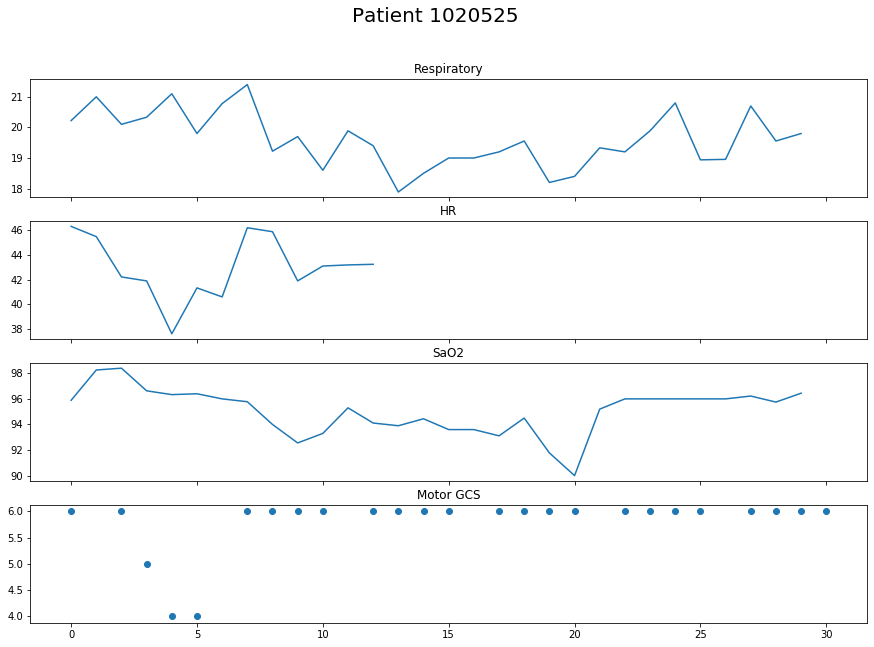

In [127]:
# get one patient's data
ind_slice = np.argwhere(hr_grouped['patientunitstayid'] == 1020525).flatten()
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(15,10))
f.suptitle("Patient 1020525", size = 20)
ax1.plot(np.arange(resp_grouped[resp_grouped.index.isin(ind_slice)]['value'].shape[0]),
         resp_grouped[resp_grouped.index.isin(ind_slice)]['value'])
ax1.set_title("Respiratory")

ax2.plot(np.arange(hr_grouped[hr_grouped.index.isin(ind_slice)]['value'].shape[0]),
         hr_grouped[hr_grouped.index.isin(ind_slice)]['value'])
ax2.set_title("HR")

ax3.plot(np.arange(sao2_grouped[sao2_grouped.index.isin(ind_slice)]['value'].shape[0]),
         sao2_grouped[sao2_grouped.index.isin(ind_slice)]['value'])
ax3.set_title("SaO2")

ax4.scatter(gcs_grouped[gcs_grouped.index.isin(ind_slice)]['offset_bin'], gcs_grouped[gcs_grouped.index.isin(ind_slice)]['value'])
ax4.set_title("Motor GCS")

## Prepare Datasets

In [128]:
# interpolate signal
hr_first24 = hr_grouped.copy()
resp_first24 = resp_grouped.copy()
sao2_first24 = sao2_grouped.copy()
gcs_first24 = gcs_grouped.copy()

hr_first24['value'] = hr_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
resp_first24['value'] = resp_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
sao2_first24['value'] = sao2_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
gcs_first24['value'] = gcs_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']

In [129]:
# get first 24 hrs
myInt = 24.0 / summarization_int

hr_first24 = hr_first24.loc[hr_first24['offset_bin'] < myInt].drop(columns=['offset', 'offset_bin'])
resp_first24 = resp_first24.loc[resp_first24['offset_bin'] < myInt].drop(columns=['offset', 'offset_bin'])
sao2_first24 = sao2_first24.loc[sao2_first24['offset_bin'] < myInt].drop(columns=['offset', 'offset_bin'])
gcs_first24 = gcs_first24.loc[gcs_first24['offset_bin'] < myInt].drop(columns=['offset', 'offset_bin'])

# fill remaining na fields (beginning of patient stay if any) with overall signal mean (maybe median itf?)
hr_first24['value'] = hr_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(method='bfill'))
resp_first24['value'] = resp_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(method='bfill'))
sao2_first24['value'] = sao2_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(method='bfill'))
gcs_first24['value'] = gcs_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(method='bfill'))

#hr_first24['value'] = hr_first24.groupby('patientunitstayid').transform(lambda x: x.median())
#resp_first24['value'] = resp_first24.groupby('patientunitstayid').transform(lambda x: x.median())
#sao2_first24['value'] = sao2_first24.groupby('patientunitstayid').transform(lambda x: x.median())
#gcs_first24['value'] = gcs_first24.groupby('patientunitstayid').transform(lambda x: x.median())

#display(resp_first24)
#display(sao2_first24)

In [130]:
further_exclusion = hr_first24.loc[hr_first24.isna()['value']]['patientunitstayid'].unique()
further_exclusion = np.hstack([further_exclusion, resp_first24.loc[resp_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.hstack([further_exclusion, sao2_first24.loc[sao2_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.hstack([further_exclusion, gcs_first24.loc[gcs_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.unique(further_exclusion)
#print(further_exclusion.shape)

In [131]:
# organize by patient

# first grab all the patient ids

# ISSUE: some patients are not represented, need to think of how to include them, perhaps -1?
keys1, keys2, keys3, keys4 = hr['patientunitstayid'].unique(), resp['patientunitstayid'].unique(), sao2['patientunitstayid'].unique(), final_gcs['patientunitstayid'].unique()
keys = []
for k in keys1:
    if (k in keys2) and (k in keys3) and (k in keys4) and (k not in further_exclusion):
        keys.append(k)

# now stack data based on the same patient order
X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_hr = X_hr.T
X_resp = X_resp.T
X_sao2 = X_sao2.T
X_gcs = X_gcs.T
#print(X_gcs)

# Modeling

In [132]:
# SET PARAMETERS

# number of pca components to extract
num_components = 40

# number of fourier features to extract
num_fourier_components = 40

# choose resampling technique
resampling = 'over'

# select model family
model_family = 'logistic'

In [141]:
id_df = pd.DataFrame(keys, columns =['patientunitstayid'])
# id_df.head()
labtypedata_cts_allids = labtypedata_cts.merge(id_df, how='right', on='patientunitstayid')
labtypedata_cts_allids = labtypedata_cts_allids.fillna(0)
#print(labtypedata_cts_allids.shape)
labtypedata_cts_allids.head()

,patientunitstayid,Hct,Hgb,MCV,RBC,platelets x 1000,WBC x 1000,MCHC,RDW,chloride,sodium,glucose,calcium,bicarbonate,creatinine,BUN,potassium
0,172448,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,242714,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,242825,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,243176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,243493,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [134]:
labtypedata_avgs_allids = labtypedata_avgs.merge(id_df, how='right', on='patientunitstayid')
#print(labtypedata_avgs_allids.shape)
for l in labtypedata_avgs_allids.columns:
    if l != 'patientunitstayid':
        col = labtypedata_avgs_allids[l]
        labtypedata_avgs_allids[l] = col.fillna(lab_avgs_map[l])
# labtypedata_avgs_allids = labtypedata_avgs_allids.fillna(-1)
#labtypedata_avgs_allids.head()

In [135]:
dem_allids = demographic.merge(id_df, how='right', on='patientunitstayid')
dem_allids = dem_allids.drop_duplicates()
#print(dem_allids.shape)
dem_allids = dem_allids.fillna(dem_allids.mean())
# labtypedata_avgs_allids = labtypedata_avgs_allids.fillna(-1)
#dem_allids.head()

death = died.merge(id_df, how = 'right', on = 'patientunitstayid')
deathstatus = death['alive'].values[:, np.newaxis]

In [ ]:
medication_allids = medtypedata.merge(id_df, how='right', on='patientunitstayid')
print(medication_allids.shape)
# Filling in NA with 0
medication_allids = medication_allids.fillna(0)

medication_allids.head()

In [ ]:
infusion_allids = infusiontypedata.merge(id_df, how='right', on='patientunitstayid')
print(infusion_allids.shape)
# Filling in NA with 0
infusion_allids = infusion_allids.fillna(0)

infusion_allids.head()

In [136]:
labavg_cols = []
for c in labtypedata_avgs_allids.columns:
    if c != 'patientunitstayid':
        labavg_cols.append(c)
X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
        None] for g in keys])[0]

labcts_cols = []
for c in labtypedata_cts_allids.columns:
    if c != 'patientunitstayid':
        labcts_cols.append(c)
X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
        None] for g in keys])[0]

dem_cols = []
for c in dem_allids.columns:
    if c != 'patientunitstayid':
        dem_cols.append(c)
X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in keys])[0]

In [ ]:
medication_cols = []
for c in medication_allids.columns:
    if c != 'patientunitstayid':
        medication_cols.append(c)
X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in keys])[0]

infusion_cols = []
for c in infusion_allids.columns:
    if c != 'patientunitstayid':
        infusion_cols.append(c)
X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in keys])[0]

In [137]:
mort = False
scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_gcs)
X_gcs_pca = raw_pca.transform(scaler.fit_transform(X_gcs))

pca_time = True
if pca_time:
    raw_pca = PCA(n_components = 5)
    raw_pca.fit(X_hr)
    X_hr_pca = raw_pca.transform(scaler.fit_transform(X_hr))
    raw_pca.fit(X_resp)
    X_resp_pca = raw_pca.transform(scaler.fit_transform(X_resp))
    raw_pca.fit(X_sao2)
    X_sao2_pca = raw_pca.transform(scaler.fit_transform(X_sao2))   

else:
    X_hr_pca = np.hstack([np.mean(X_hr, axis = 1)[:, np.newaxis], np.std(X_hr, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis]])

    X_resp_pca = np.hstack([np.mean(X_resp, axis = 1)[:, np.newaxis], np.std(X_resp, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis]])

    X_sao2_pca = np.hstack([np.mean(X_sao2, axis = 1)[:, np.newaxis], np.std(X_sao2, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis],
                        np.std(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis]])

X_phys = np.hstack([X_hr_pca, X_resp_pca, X_sao2_pca, X_gcs_pca])
X_phys = scaler.fit_transform(X_phys)

X_labdem = np.hstack([X_labavgs, X_labcts, X_dem])
scaler.fit(X_labdem)
X_labdem = scaler.transform(X_labdem)

X_naive = np.hstack([X_phys, X_labdem])
target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
        None] for g in keys])

# split data
if mort:
    trainX, testX, trainY, testY = train_test_split(X_naive, deathstatus, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()
else:
    trainX, testX, trainY, testY = train_test_split(X_naive, target_gcs, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()

# resample
if resampling == 'over':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
    
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

elif resampling == 'under':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
        
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

In [138]:
# modify labels
if mort:
    testY_mod = testY.copy()
    testY_mod[testY == False] = 0
    testY_mod[testY == True] = 1

    trainY_mod = trainY.copy()
    trainY_mod[trainY ==False] = 0
    trainY_mod[trainY == True] = 1

else:
    testY_mod = testY.copy()
    testY_mod[testY < 6] = 1
    testY_mod[testY == 6] = 0

    trainY_mod = trainY.copy()
    trainY_mod[trainY < 6] = 1
    trainY_mod[trainY == 6] = 0

# train model
model_family = 'logistic'
if model_family == 'logistic':
    clf = LogisticRegression(max_iter=2000, penalty='elasticnet', l1_ratio=0.5,
                         solver='saga', C=.8)
    
elif model_family == 'random_forest':
    clf = RandomForestClassifier(max_depth=2, n_estimators=10)

print(trainX.shape)
clf.fit(trainX, trainY_mod)
print("Train Score:", clf.score(trainX, trainY_mod))

(2464, 60)
Train Score: 0.8583603896103896


Test Score: 0.8948
AUC: 0.9139
Sensitivity: 0.617
Specificity: 0.9663
Precision: 0.7333
Recall: 0.7801


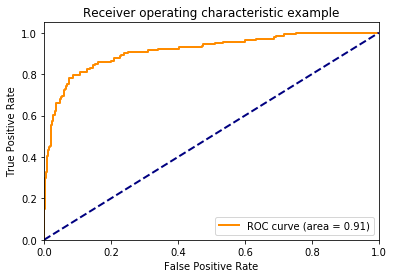

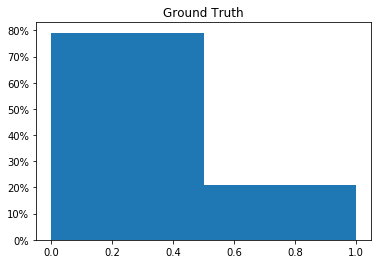

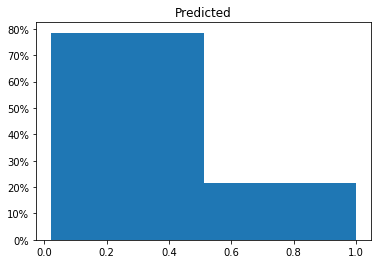

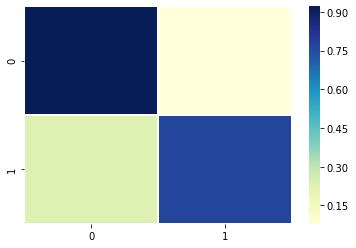

In [139]:
# test model
predY = clf.predict_proba(testX)[:, 1]
print("Test Score:", np.round(clf.score(testX, testY_mod), 4))

# get auc
auc = roc_auc_score(testY_mod, predY)
print("AUC:", np.round(auc, 4))

# plot roc curve
fpr, tpr, roc_thresholds = roc_curve(testY_mod, predY)
precision, recall, thresholds = precision_recall_curve(testY_mod, predY)

# optimize for precision and recall
best_pr_thresh = np.argmax(np.square(precision) + np.square(recall))

# find corresponding threshold index for roc curve (thresholds are reverse order)
roc_thresh = int(roc_thresholds.shape[0] * (1 - best_pr_thresh / thresholds.shape[0]))

#print('roc thresh:', roc_thresholds.shape)
#print('pr thresh:', thresholds.shape)

print("Sensitivity: " + str(np.round(tpr[roc_thresh], 4)))
print("Specificity: " + str(np.round(1 - fpr[roc_thresh], 4)))
print("Precision: " + str(np.round(precision[best_pr_thresh], 4)))
print("Recall: " + str(np.round(recall[best_pr_thresh], 4)))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# class balance
plt.hist(testY_mod, bins=2, weights=np.ones(len(testY_mod)) / len(testY_mod))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Ground Truth")
plt.show()

plt.hist(predY, bins=2, weights=np.ones(len(predY)) / len(predY))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Predicted")
plt.show()

# heatmap
predY = predY > thresholds[bestThreshInd]
confusion = confusion_matrix(predY, testY_mod)
confusion = confusion / np.sum(confusion, axis=1)[:, None]
heatmap = sns.heatmap(confusion, linewidths=.5, cmap="YlGnBu")